# 3D-VAR vs AI-VAR with Modulated Sine as Background 
## Case with 1 sample only

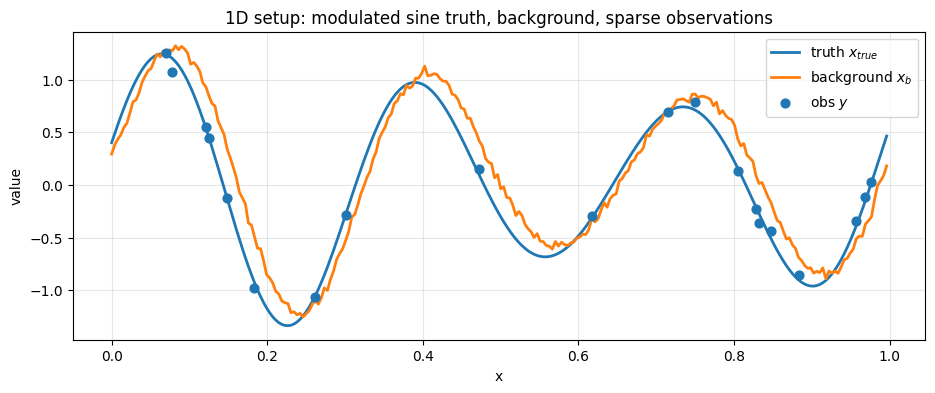

n=256 grid points, m=20 observations, obs_sigma=0.05
obs_idx (first 10): [ 18  20  31  32  38  47  67  77 121 158]


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Reproducibility
# ----------------------------
rng = np.random.default_rng(7)

# ----------------------------
# 1D grid (LOCKED NAME)
# ----------------------------
n = 256
x_grid = np.linspace(0.0, 1.0, n, endpoint=False)   # periodic grid in [0,1)

# ----------------------------
# "True" state: modulated sine
#   y(x) = A(x) * sin(2π k x + phase) + trend
# ----------------------------
k = 3.0
phase = 0.4
A0 = 1.0
A1 = 0.35
A_mod_k = 1.0  # modulation wavenumber

A = A0 + A1 * np.sin(2*np.pi*A_mod_k * x_grid + 0.7)
trend = 0.15 * (x_grid - 0.5)
x_true = A * np.sin(2*np.pi*k * x_grid + phase) + trend

# ----------------------------
# Background xb: biased + smoothed + small noise
# ----------------------------
bias = 0.10
shift = 4  # grid points, periodic shift
x_shifted = np.roll(x_true, shift)

# simple smoothing via convolution (periodic padding)
sigma_pts = 2.0
radius = int(np.ceil(4 * sigma_pts))
t = np.arange(-radius, radius + 1)
ker = np.exp(-(t**2) / (2 * sigma_pts**2))
ker /= ker.sum()

x_pad = np.r_[x_shifted[-radius:], x_shifted, x_shifted[:radius]]
x_smooth = np.convolve(x_pad, ker, mode="same")[radius:-radius]

xb = x_smooth + bias + 0.03 * rng.standard_normal(n)

# ----------------------------
# Observations at selected points
# ----------------------------
m = 20  # number of obs
obs_idx = np.sort(rng.choice(n, size=m, replace=False))

obs_sigma = 0.05
y = x_true[obs_idx] + obs_sigma * rng.standard_normal(m)

# optional: mask out some obs as missing (NaN)
missing_frac = 0.0
if missing_frac > 0:
    miss = rng.random(m) < missing_frac
    y = y.copy()
    y[miss] = np.nan

# convenience: obs on full grid
y_on_grid = np.full(n, np.nan, dtype=float)
y_on_grid[obs_idx] = y

# ----------------------------
# Plot
# ----------------------------
fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax.plot(x_grid, x_true, lw=2, label="truth $x_{true}$")
ax.plot(x_grid, xb, lw=2, label="background $x_b$")
ax.scatter(x_grid[obs_idx], y, s=40, marker="o", label="obs $y$", zorder=5)

ax.set_xlabel("x")
ax.set_ylabel("value")
ax.set_title("1D setup: modulated sine truth, background, sparse observations")
ax.grid(True, alpha=0.3)
ax.legend(loc="best")
plt.savefig("1d_xt_xb_obs.png")
plt.show()

# ----------------------------
# Info
# ----------------------------
print(f"n={n} grid points, m={m} observations, obs_sigma={obs_sigma}")
print("obs_idx (first 10):", obs_idx[:10])


B shape: (256, 256)
diag(B): 0.0625
cond(B): 573425.1573160174


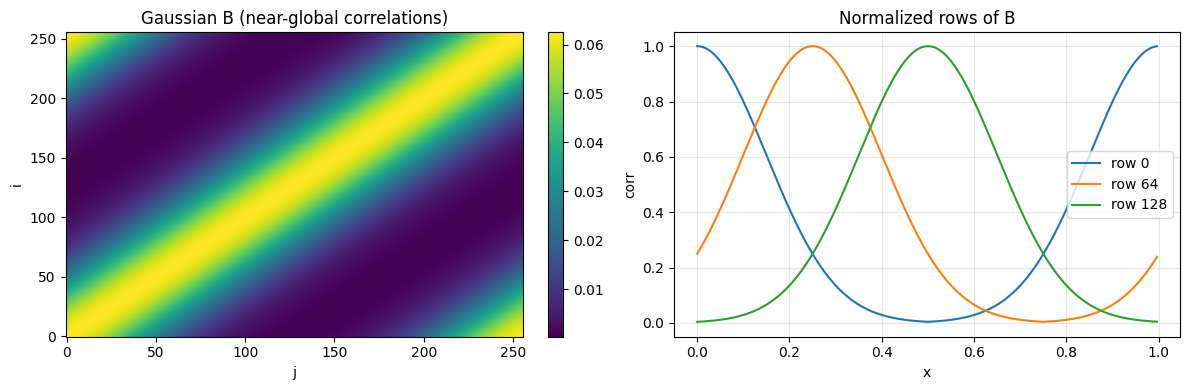

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# Grid (reuse x_grid, n from cell 1)
# -------------------------------------------------
# assumes:
#   x_grid : shape (n,)
#   n      : int

# -------------------------------------------------
# B-matrix parameters
# -------------------------------------------------
sigma_b = 0.25
L = 0.15     # correlation length

# -------------------------------------------------
# Periodic distance matrix
# -------------------------------------------------
X_i = x_grid[:, None]
X_j = x_grid[None, :]

dist = np.abs(X_i - X_j)
dist = np.minimum(dist, 1.0 - dist)   # periodic distance

# -------------------------------------------------
# Gaussian covariance
# -------------------------------------------------
B = (sigma_b**2) * np.exp(-(dist**2) / (2 * L**2))

# -------------------------------------------------
# Diagnostics
# -------------------------------------------------
print("B shape:", B.shape)
print("diag(B):", B.diagonal()[0])
print("cond(B):", np.linalg.cond(B))

# -------------------------------------------------
# Visualization
# -------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- full matrix ---
im = axes[0].imshow(
    B,
    origin="lower",
    aspect="auto",
    cmap="viridis"
)
axes[0].set_title("Gaussian B (near-global correlations)")
axes[0].set_xlabel("j")
axes[0].set_ylabel("i")
plt.colorbar(im, ax=axes[0], fraction=0.046)

# --- normalized rows ---
rows = [0, n // 4, n // 2]
for r in rows:
    axes[1].plot(
        x_grid,
        B[r] / B[r, r],
        label=f"row {r}"
    )

axes[1].set_title("Normalized rows of B")
axes[1].set_xlabel("x")
axes[1].set_ylabel("corr")
axes[1].set_ylim(-0.05, 1.05)
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig("1d_B_matrix.png")
plt.show()


H shape: (20, 256)
Hx_b shape: (20,)
Max |Hx_b - xb[obs_idx]|: 0.0


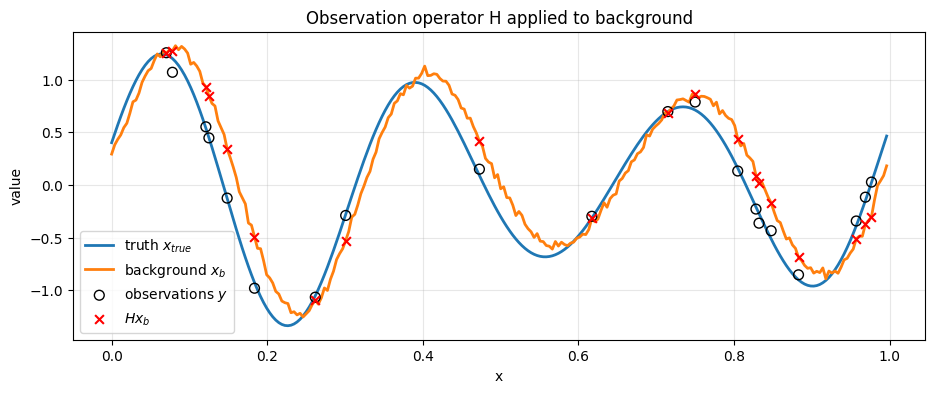

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# Assumes from previous cells:
#   x_grid   : grid (n,)
#   xb       : background state (n,)
#   x_true   : true state (n,)
#   obs_idx  : observation indices (m,)
#   y        : observations (m,)
# -------------------------------------------------

n = x_grid.size
m = obs_idx.size

# -------------------------------------------------
# Observation operator H (point sampling)
# -------------------------------------------------
H = np.zeros((m, n))
for k, i in enumerate(obs_idx):
    H[k, i] = 1.0

# -------------------------------------------------
# Apply H
# -------------------------------------------------
Hx_b    = H @ xb
Hx_true = H @ x_true

# -------------------------------------------------
# Consistency check
# -------------------------------------------------
print("H shape:", H.shape)
print("Hx_b shape:", Hx_b.shape)
print(
    "Max |Hx_b - xb[obs_idx]|:",
    np.max(np.abs(Hx_b - xb[obs_idx]))
)

# -------------------------------------------------
# Visualization
# -------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(11, 4))

ax.plot(x_grid, x_true, lw=2, label="truth $x_{true}$")
ax.plot(x_grid, xb, lw=2, label="background $x_b$")

ax.scatter(
    x_grid[obs_idx],
    y,
    s=50,
    marker="o",
    facecolors="none",
    edgecolors="k",
    label="observations $y$",
    zorder=6
)

ax.scatter(
    x_grid[obs_idx],
    Hx_b,
    s=40,
    marker="x",
    color="red",
    label=r"$H x_b$",
    zorder=7
)

ax.set_xlabel("x")
ax.set_ylabel("value")
ax.set_title("Observation operator H applied to background")
ax.grid(True, alpha=0.3)
ax.legend()
plt.savefig("1d_xt_y_xb_Hxb.png")
plt.show()


||xa - xb||: 3.2115007756868534
||H xb - y||: 1.255460680239772
||H xa - y||: 0.2794113946801047


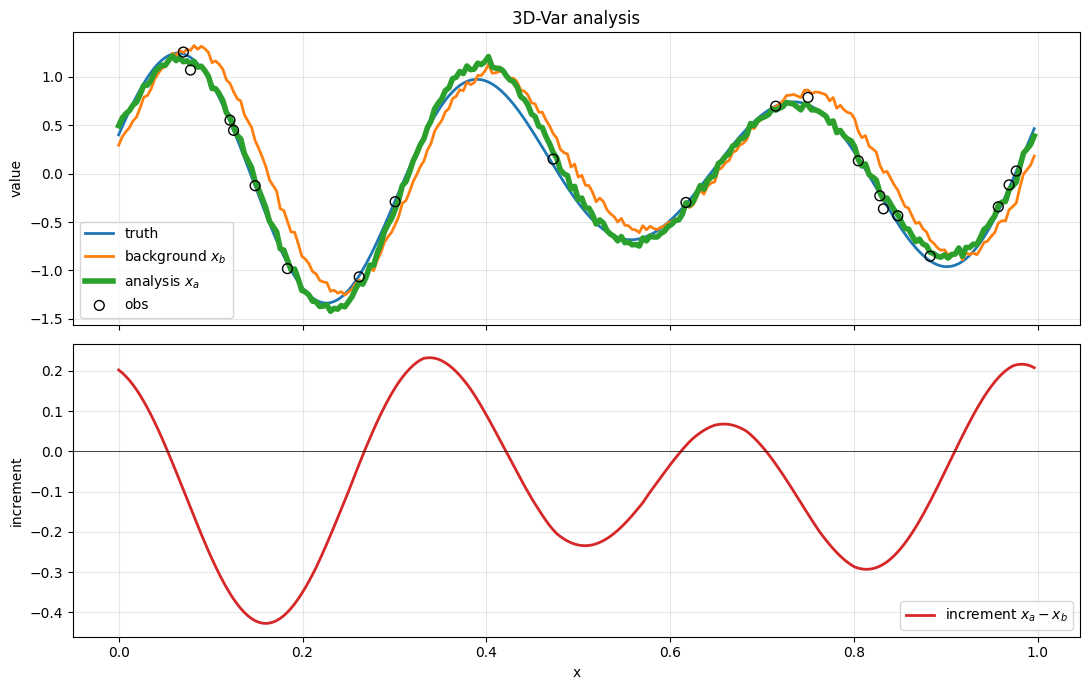

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# Assumes from previous cells:
#   x_grid  : grid (n,)
#   x_true  : true state (n,)
#   xb      : background state (n,)
#   B       : background covariance (n,n)
#   H       : observation operator (m,n)
#   obs_idx : observation indices (m,)
#   y       : observations (m,)
# -------------------------------------------------

n = x_grid.size
m = obs_idx.size

# -------------------------------------------------
# Observation error covariance R
# -------------------------------------------------
obs_sigma = 0.05   # must match generation of y
R = (obs_sigma**2) * np.eye(m)

# -------------------------------------------------
# Innovations
# -------------------------------------------------
d = y - H @ xb     # innovation vector

# -------------------------------------------------
# 3D-Var gain components
# -------------------------------------------------
HBHT = H @ B @ H.T
S = HBHT + R
S_inv = np.linalg.inv(S)

# -------------------------------------------------
# Analysis
# -------------------------------------------------
xa = xb + B @ H.T @ (S_inv @ d)

# -------------------------------------------------
# Diagnostics
# -------------------------------------------------
print("||xa - xb||:", np.linalg.norm(xa - xb))
print("||H xb - y||:", np.linalg.norm(H @ xb - y))
print("||H xa - y||:", np.linalg.norm(H @ xa - y))

# -------------------------------------------------
# Visualization
# -------------------------------------------------
fig, axes = plt.subplots(2, 1, figsize=(11, 7), sharex=True)

# --- state space ---
axes[0].plot(x_grid, x_true, lw=2, label="truth")
axes[0].plot(x_grid, xb, lw=2, label="background $x_b$")
axes[0].plot(x_grid, xa, lw=4, label="analysis $x_a$")

axes[0].scatter(
    x_grid[obs_idx], y,
    s=50, facecolors="none", edgecolors="k",
    label="obs", zorder=6
)

axes[0].set_ylabel("value")
axes[0].set_title("3D-Var analysis")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# --- increments ---
axes[1].plot(x_grid, xa - xb, lw=2, label=r"increment $x_a - x_b$", color="tab:red")
axes[1].axhline(0.0, color="k", lw=0.5)
axes[1].set_xlabel("x")
axes[1].set_ylabel("increment")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig("1d_xa_3dvar.png")
plt.show()


# ML Approach

alpha (relative): 1e-05
lambda_max:        6.010741988913985
lambda_floor:      6.0107419889139855e-05
min(lambda):       -0.0015056407018105879
min(lambda_reg):   6.0107419889139855e-05
symmetry error: 1.5672022852877118e-16


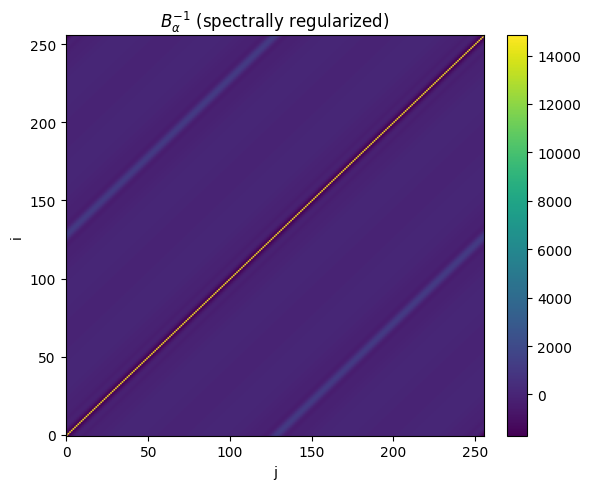

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# Grid
# -------------------------------------------------
n = x_grid.size

# -------------------------------------------------
# USER PARAMETER: spectral regularization strength
# -------------------------------------------------
alpha = 1e-5   # relative eigenvalue floor (increase if you want smoother increments)

# ----------------------------
# Build B with L = 0.15
# ----------------------------
sigma_b = 0.25
L = 0.15

X_i = x_grid[:, None]
X_j = x_grid[None, :]

dist = np.abs(X_i - X_j)
dist = np.minimum(dist, 1.0 - dist)

B = (sigma_b**2) * np.exp(-(dist**2) / (2 * L**2))

# enforce symmetry
B = 0.5 * (B + B.T)

# -------------------------------------------------
# Spectral regularization (THIS is the key)
#   B = U diag(λ) U^T
#   λ_reg = max(λ, alpha * max(λ))
# -------------------------------------------------
lam, U = np.linalg.eigh(B)

lam_max = lam.max()
lam_floor = alpha * lam_max

lam_reg = np.maximum(lam, lam_floor)

print("alpha (relative):", alpha)
print("lambda_max:       ", lam_max)
print("lambda_floor:     ", lam_floor)
print("min(lambda):      ", lam.min())
print("min(lambda_reg):  ", lam_reg.min())

# -------------------------------------------------
# Build regularized inverse
# -------------------------------------------------
Breg_inv = (U * (1.0 / lam_reg)) @ U.T

# -------------------------------------------------
# Sanity check: symmetry & positivity
# -------------------------------------------------
sym_err = np.linalg.norm(Breg_inv - Breg_inv.T) / np.linalg.norm(Breg_inv)
print("symmetry error:", sym_err)

# -------------------------------------------------
# Visualization
# -------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
im = ax.imshow(
    Breg_inv,
    origin="lower",
    aspect="auto",
    cmap="viridis"
)
ax.set_title(r"$B_\alpha^{-1}$ (spectrally regularized)")
ax.set_xlabel("j")
ax.set_ylabel("i")
plt.colorbar(im, ax=ax, fraction=0.046)
plt.tight_layout()
plt.show()


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# -------------------------------------------------
# Torch setup
# -------------------------------------------------
device = torch.device("cpu")
dtype  = torch.float64   # << IMPORTANT: use double precision

# -------------------------------------------------
# Convert numpy → torch
# -------------------------------------------------
xb_t = torch.tensor(xb, dtype=dtype, device=device)
y_t  = torch.tensor(y,  dtype=dtype, device=device)

B_inv_t = torch.tensor(Breg_inv, dtype=dtype, device=device)
H_t     = torch.tensor(H, dtype=dtype, device=device)
R_inv_t = torch.tensor(np.linalg.inv(R), dtype=dtype, device=device)

# -------------------------------------------------
# Enforce symmetry (CRITICAL for convergence)
# -------------------------------------------------
B_inv_t = 0.5 * (B_inv_t + B_inv_t.T)
R_inv_t = 0.5 * (R_inv_t + R_inv_t.T)

n = xb_t.numel()
m = y_t.numel()

# -------------------------------------------------
# MLP for increment δx
# -------------------------------------------------
class IncrementMLP(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, n)
        )

    def forward(self, xb):
        return self.net(xb)

model = IncrementMLP(n).to(device).to(dtype)

# -------------------------------------------------
# Stable quadratic form
# -------------------------------------------------
def quadform(A, v):
    return torch.dot(v, A @ v)

# -------------------------------------------------
# 3D-Var cost function J(xb + δx)
# -------------------------------------------------
def J_3dvar(delta_x):
    """
    delta_x : (n,)
    """
    x_state = xb_t + delta_x
    innov   = y_t - (H_t @ x_state)

    Jb = 0.5 * quadform(B_inv_t, delta_x)
    Jo = 0.5 * quadform(R_inv_t, innov)

    return Jb + Jo, Jb, Jo


In [7]:
# -------------------------------------------------
# Optimizer: L-BFGS (critical for this problem)
# -------------------------------------------------
optimizer = optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter=20,
    history_size=50,
    line_search_fn="strong_wolfe"
)

# -------------------------------------------------
# Training loop
# -------------------------------------------------
n_epochs = 200
log_every = 50

loss_history = []

for ep in range(1, n_epochs + 1):

    def closure():
        optimizer.zero_grad()

        delta_x = model(xb_t)
        J, Jb, Jo = J_3dvar(delta_x)

        J.backward()

        # store for logging
        closure.J  = J.detach()
        closure.Jb = Jb.detach()
        closure.Jo = Jo.detach()

        return J

    optimizer.step(closure)

    J  = float(closure.J.cpu())
    Jb = float(closure.Jb.cpu())
    Jo = float(closure.Jo.cpu())

    loss_history.append(J)

    if ep % log_every == 0 or ep == 1:
        print(
            f"ep {ep:4d} | "
            f"J={J:.6e} | "
            f"Jb={Jb:.6e} | "
            f"Jo={Jo:.6e}"
        )

print("Training finished.")


ep    1 | J=3.463705e+02 | Jb=5.201037e+01 | Jo=2.943601e+02
ep   50 | J=4.894941e+01 | Jb=3.382028e+01 | Jo=1.512913e+01
ep  100 | J=4.894941e+01 | Jb=3.382028e+01 | Jo=1.512913e+01
ep  150 | J=4.894941e+01 | Jb=3.382028e+01 | Jo=1.512913e+01
ep  200 | J=4.894941e+01 | Jb=3.382028e+01 | Jo=1.512913e+01
Training finished.


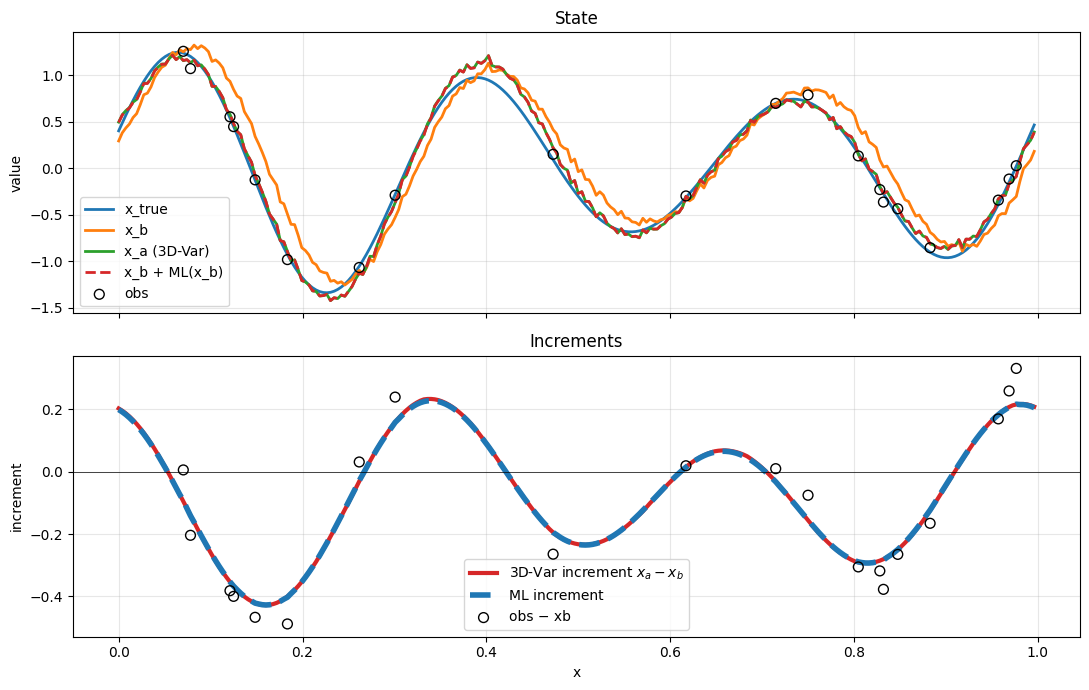

In [8]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# -------------------------------------------------
# Evaluate ML model (increment only)
# -------------------------------------------------
with torch.no_grad():
    delta_x_ml = model(xb_t).cpu().numpy()
    xa_ml = xb + delta_x_ml

# -------------------------------------------------
# Observation increments (obs - xb at obs points)
# -------------------------------------------------
obs_incr = y - xb[obs_idx]

# -------------------------------------------------
# Sanity plot: states + increments + observations
# -------------------------------------------------
fig, axes = plt.subplots(2, 1, figsize=(11, 7), sharex=True)

# =================================================
# Row 1: states
# =================================================
axes[0].plot(x_grid, x_true, lw=2, label="x_true")
axes[0].plot(x_grid, xb,     lw=2, label="x_b")
axes[0].plot(x_grid, xa,     lw=2, label="x_a (3D-Var)")
axes[0].plot(x_grid, xa_ml,  "--", lw=2, label="x_b + ML(x_b)")

# observations (full state space)
axes[0].scatter(
    x_grid[obs_idx],
    y,
    s=50,
    facecolors="none",
    edgecolors="k",
    label="obs",
    zorder=6
)

axes[0].set_ylabel("value")
axes[0].set_title("State")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# =================================================
# Row 2: increments
# =================================================
axes[1].plot(
    x_grid,
    xa - xb,
    lw=3,
    color="tab:red",
    label="3D-Var increment $x_a - x_b$"
)
axes[1].plot(
    x_grid,
    xa_ml - xb,
    "--",
    lw=4,
    label="ML increment"
)

# observation increments at obs points
axes[1].scatter(
    x_grid[obs_idx],
    obs_incr,
    s=50,
    facecolors="none",
    edgecolors="k",
    label="obs − xb",
    zorder=6
)

axes[1].axhline(0.0, color="k", lw=0.5)
axes[1].set_xlabel("x")
axes[1].set_ylabel("increment")
axes[1].set_title("Increments")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig("1d_xa_MLP.png")
plt.show()
